In [3]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from sklearn.datasets import make_blobs
from sklearn.utils import shuffle

X1, y1 = make_blobs(n_samples=1000, centers=((4, -4), (0, 0)), random_state=1)
X1 = X1.dot(np.array([[0.374, 0.95], [0.732, 0.598]]))
X2, y2 = make_blobs(n_samples=250, centers=1, random_state=1)
X2 = X2 + [6, -8]
X = np.r_[X1, X2]
y = np.r_[y1, y2]
print(X)

[[-0.63557094  1.88086168]
 [-0.80079177  2.02977997]
 [ 0.17976229  0.47837497]
 ...
 [ 5.32677528 -3.37997623]
 [ 4.79205604 -2.4893358 ]
 [ 5.35056727 -2.6734922 ]]


In [28]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.stats import multivariate_normal as mvn
import copy
from sklearn.cluster import KMeans

class custom_gmm():
    #initialize gmm for dataset and k classes
    def __init__(self, data, k, cov_init=1, kmeans=True):
        self.data = copy.deepcopy(data)
        self.k = k
        self.n = len(self.data)
        self.f = len(self.data[0])
        #run kmeans and use centroids for decent mu initialization
        if kmeans:
            kmeans = KMeans(n_clusters=k).fit(self.data)
            self.mus = kmeans.cluster_centers_
        else:
            self.mus = self.data[np.random.choice(np.arange(self.n), self.k)]
        #initialize k covariance matrices as identity matrices
        self.covs = np.array([np.asmatrix(np.identity(self.f)) for i in range(self.k)]) * cov_init
        #intialize all mixes as equal
        self.mixes = np.ones(self.k) / self.k
        #initialize class likelihood probabilities as empty
        self.probs = np.empty((self.n, self.k))
        
    #assign probabilities each data point is in each class
    def e_step(self):
        s = 0
        for i in range(self.k):
            p = mvn.pdf(self.data, self.mus[i,:].ravel(), self.covs[i,:]) * self.mixes[i]
            s += p
            self.probs[:,i] = p
        self.probs = self.probs / s[:,None]
        
    #update mixer, mu, and cov matrix for each class
    def m_step(self):
        for i in range(self.k):
            #update mixer
            s = self.probs[:,i].sum()
            self.mixes[i] = s / self.n 
            #update mu
            new_mu = self.data.T @ self.probs[:, i]
            self.mus[i] = new_mu.reshape(1,self.f) / s
            #update cov
            dif = self.data - self.mus[i]
            diag = np.diag(np.diag(np.diag(self.probs[:,i])))
            new_cov = (diag @ dif).T @ dif
            self.covs[i] = new_cov / s
            
    #get log likelihood of model at its current stage
    def log_like(self):
        like = 0
        for i in range(self.k):
            like += mvn.pdf(self.data, self.mus[i,:].ravel(), self.covs[i,:]) * self.mixes[i]
        ll = np.log(like).sum()
        return ll
    
    #fit k gaussians to data until convergence within threshold
    def fit(self, thresh = 0.0001):
        like = 1
        prev_like = 0
        #perform e step then m step until log likelihood converges
        while np.abs(like - prev_like) > thresh:
            prev_like = self.log_like()
            self.e_step()
            self.m_step()
            like = self.log_like()
            
    #predict class and probability of new data
    def predict(self, data):
        s = 0
        probs = np.asmatrix(np.empty((len(data), self.k)))
        for i in range(self.k):
            p = mvn.pdf(data, self.mus[i,:].ravel(), self.covs[i,:])
            s += p[:,None]
            probs[:,i] = p[:,None]
        return pd.DataFrame(np.hstack((np.argmax(probs, axis=1), np.max(probs, axis=1) / s)))
    
            

    #return class predictions for each data point  
    def get_labs(self):
        return pd.DataFrame(np.argmax(self.probs, axis=1))
    
    #return whether a data point is an anomaly or not
    #Checks if assignment prob is less than a condifence
    def get_anoms(self, conf=0.05):
        labs = []
        Ps = np.max(self.probs, axis=1)
        for p in Ps:
            if p < conf:
                labs.append(1)
            else:
                labs.append(0)
        return pd.DataFrame(labs)

In [25]:
gmm = custom_gmm(X, 3)

In [26]:
gmm.fit()
y = gmm.get_labs()
anom = gmm.get_anoms(conf=0.95)

In [27]:
new = np.array([[0,0],[4,-4]])
print(new)
gmm.predict(new)

[[ 0  0]
 [ 4 -4]]


,0,1
0,0.0,1.0
1,1.0,1.0


In [15]:
gmm.probs

array([[1.12107365e-004, 2.35389196e-012, 9.99887893e-001],
       [4.01171780e-006, 2.91428634e-013, 9.99995988e-001],
       [9.99999153e-001, 2.54629932e-008, 8.21493869e-007],
       ...,
       [5.06633477e-065, 1.00000000e+000, 1.68336285e-122],
       [6.13094750e-047, 1.00000000e+000, 5.11073770e-096],
       [2.76730435e-057, 1.00000000e+000, 2.83572416e-111]])

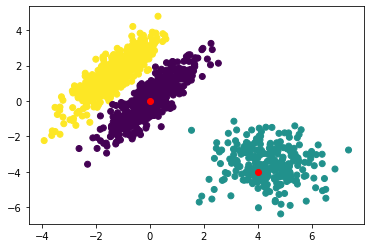

In [16]:
plt.scatter(X[:,0], X[:,1], c=y, cmap='viridis')
# legend_aliases = [
#     plt.scatter([], [], marker='o', label='0', edgecolors = 'indigo', c='indigo'),
#     plt.scatter([], [], marker='o', label='1', edgecolors = 'yellow', c='yellow'),
#     plt.scatter([], [], marker='o', label='2', edgecolors = 'teal', c='teal')
# ]

# plt.legend(handles=legend_aliases)
plt.scatter(new[:,0], new[:,1], c='red')
plt.show()

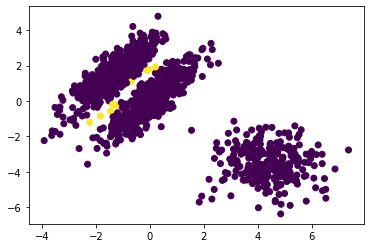

In [395]:
plt.scatter(X[:,0], X[:,1], c=anom)
plt.show()

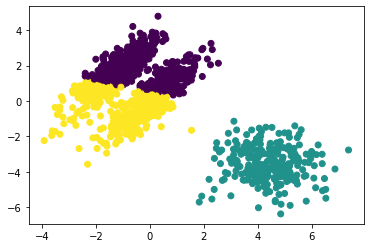

In [287]:
kmeans = KMeans(n_clusters=3).fit(X)
plt.scatter(X[:,0], X[:,1], c=kmeans.labels_)
plt.show()